In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import math
import random
from scipy import stats

import geopandas as gpd
import pandas as pd

import itertools
from collections import Counter

from ast import literal_eval

from wordcloud import WordCloud

In [104]:
import community as louvain # pip install python-louvain

In [105]:
import networkx as nx
from networkx.algorithms import community

from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Category20
from bokeh.transform import linear_cmap

from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges

In [106]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import data

In [27]:
def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [28]:
%%time

_df = pd.read_csv("./preprocessed_data/nlp_geo_tweets_stopwords_cleaned.csv")
for col in ["hashtags", "tokens", "tokens_cleand", "w_pos_lemma"]:
    _df[col] = _df[col].apply(literal_eval)

print(_df.shape)

(328512, 26)
Wall time: 42.4 s


In [29]:
# df_ht = _df[[len(ht)>0 for ht in _df["hashtags"]]]
# df_ht.shape

In [30]:
# select only regions with more tweets than average ---> can be changed
dep_count = _df.groupby("dep_code").count()[["created_at"]]
dep_count.rename(columns={"created_at":"tweet_count"}, inplace=True)
dep_count.sort_values(by="tweet_count", ascending=False)
dep_count_filtered = dep_count[dep_count.tweet_count > dep_count.tweet_count.mean()] # can be changed
selected_dep = dep_count_filtered.index.values 
df_ht = _df[[dep in selected_dep for dep in _df.dep_code]].copy()
df_ht["hashtags"] = [[ht.lower() for ht in hashtags] for hashtags in df_ht.hashtags]
df_ht.shape

(233596, 26)

In [31]:
#all_hashtags = list(set((itertools.chain.from_iterable(df_ht["hashtags"].values))))
ht_counts = Counter(list(itertools.chain.from_iterable(df_ht["hashtags"].values)))

In [32]:
all_hashtags = [ht for ht, count in zip(ht_counts.keys(), ht_counts.values()) if count>10]
len(all_hashtags)

562

# Graph based approach

In [53]:
G = nx.Graph()

In [54]:
G.add_nodes_from(all_hashtags)

In [55]:
pairs_list = []

In [56]:
for _, row in df_ht.iterrows():
    tweet_hts = row.hashtags
    tweet_hts = [ht for ht in tweet_hts if ht in all_hashtags]
    if len(tweet_hts)>1:
        ht_pairs = [(ht_i, ht_j) for idx, ht_i in enumerate(tweet_hts) for ht_j in tweet_hts[idx + 1:]]
        G.add_edges_from(ht_pairs)
        pairs_list = pairs_list+ht_pairs

In [57]:
count_pairs = Counter(pairs_list)
#pairs_list = [(pair[0], pair[1], count_pairs[pair]) for pair in pairs_list]

In [58]:
pairs_list_u = []
pairs_list_weight = []
for pair in pairs_list:
    if (pair not in pairs_list_u) and ((pair[1], pair[0]) not in pairs_list_u):
        pairs_list_u += [pair]#, count_pairs[pair]+count_pairs[(pair[1], pair[0])])]
        pairs_list_weight += [count_pairs[pair]+count_pairs[(pair[1], pair[0])]]

In [59]:
pairs_list_u = [(pair[0], pair[1], weight) for pair, weight in zip(pairs_list_u, pairs_list_weight)]

In [60]:
G.add_weighted_edges_from(pairs_list_u)

In [98]:
communities_louvain = louvain.best_partition(G, weight='weight')

communities_louvain_arr = [[ht for ht in communities_louvain.keys() if communities_louvain[ht]==i]
                           for i in range(len(set(communities_louvain.values())))
                          ]

In [101]:
nb_coms_several_ht = 0

topic_label = ["paris live"
          , "anti-gov"
          , "soccer (ol)"
          , "french riviera"
          , "top hts"
          , "photography"
          , "sport (soccer)"
          , "nature"
          , "incident" 
          , "space"
          , "entertainment"
          , "visual arts"
          , "geluck"
          , "aah"
          , "tv shows (1)"
          , "tv shows (2)"
          , "nord est"
          , "pets"
          , "paris (drug issues)"
          , "wrestling"
         ]

print(len(communities_louvain_arr))
for com in communities_louvain_arr:
    if len(com)>=5:
        print("\n = = = = = = = = = ", topic_label[nb_coms_several_ht], " = = = = = = = = = ")
        nb_coms_several_ht += 1
        print(com)

82

 = = = = = = = = =  paris live  = = = = = = = = = 
['france', 'falconandwintersoldier', 'saccageparis', 'paris', 'gay', 'ue', 'soleil', 'montmartre', 'paris18', 'patrimoine', 'cinema', 'saccageaparis', 'culture', 'weekend', 'conseildeparis', 'usa', 'flowers', 'spring', 'printemps', 'fleurs', 'politique', 'lyon', 'immobilier', 'parismaville', 'performance', 'hidalgo', 'parisjetaime', 'kcorp', 'balade', 'ratp', 'architecture', 'blue', 'sky', 'annehidalgo', 'histoire', 'nofilter', 'ciel', 'paris20', 'paris15', 'seine', 'citation', 'springtime', 'presse', 'emploi', 'iloveparis', 'weloveparis', 'welove18', 'nord', '5g', 'strasbourg', 'paris9', 'gayparis', 'boulognebillancourt', 'friends', 'europe', 'dimanche', 'ligue_des_optimistes', 'lundifleuri', 'lundi', 'marchelesbienne', 'fakenews', 'paris17', '24avril2021', 'hautsdeseine', 'jnbat', 'jardinduluxembourg', '18avril2021']

 = = = = = = = = =  anti-gov  = = = = = = = = = 
['stopdictature', 'macrondestitution', 'stopdictaturesanitaire',

In [ ]:
df_louvain = pd.DataFrame()
df_louvain["hashtags"] = communities_louvain_arr
df_louvain = df_louvain[[len(hts)>=5 for hts in df_louvain["hashtags"]]].reset_index(drop=True)
df_louvain["name"] = topic_label
df_louvain = df_louvain[['name', 'hashtags']]
# df_louvain.to_csv("df_louvain.csv", index=False)
df_louvain

In [ ]:
df_louvain_short = pd.DataFrame()
df_louvain_short["hashtags"] = communities_louvain_arr
df_louvain_short = df_louvain_short[[len(hts)>=5 for hts in df_louvain_short["hashtags"]]].reset_index(drop=True)
df_louvain_short["name"] = topic_label
df_louvain_short["hashtags"] = [", ".join(ht[:10]) for ht in df_louvain_short["hashtags"]]
df_louvain_short = df_louvain_short[['name', 'hashtags']]
# df_louvain_short.to_csv("df_louvain_short.csv", index=False)
df_louvain_short

In [223]:
topic_label = ["paris live"
          , "anti-gov"
          , "soccer (ol)"
          , "french riviera"
          , "top hts"
          , "visual arts"
          , "photography"
          , "sport (soccer)"
          , "nature" 
          , "space"
          , "entertainment"
          , "incident"
          , "geluck"
          , "aah"
          , "tv shows (1)"
          , "tv shows (2)"
          , "nord est"
          , "pets"
          , "paris (drug issues)"
          , "wrestling"
         ]

In [224]:
df_louvain = pd.read_csv('./results_for_presentation/df_louvain.csv')
for col in ["hashtags"]:
    df_louvain[col] = df_louvain[col].apply(literal_eval)

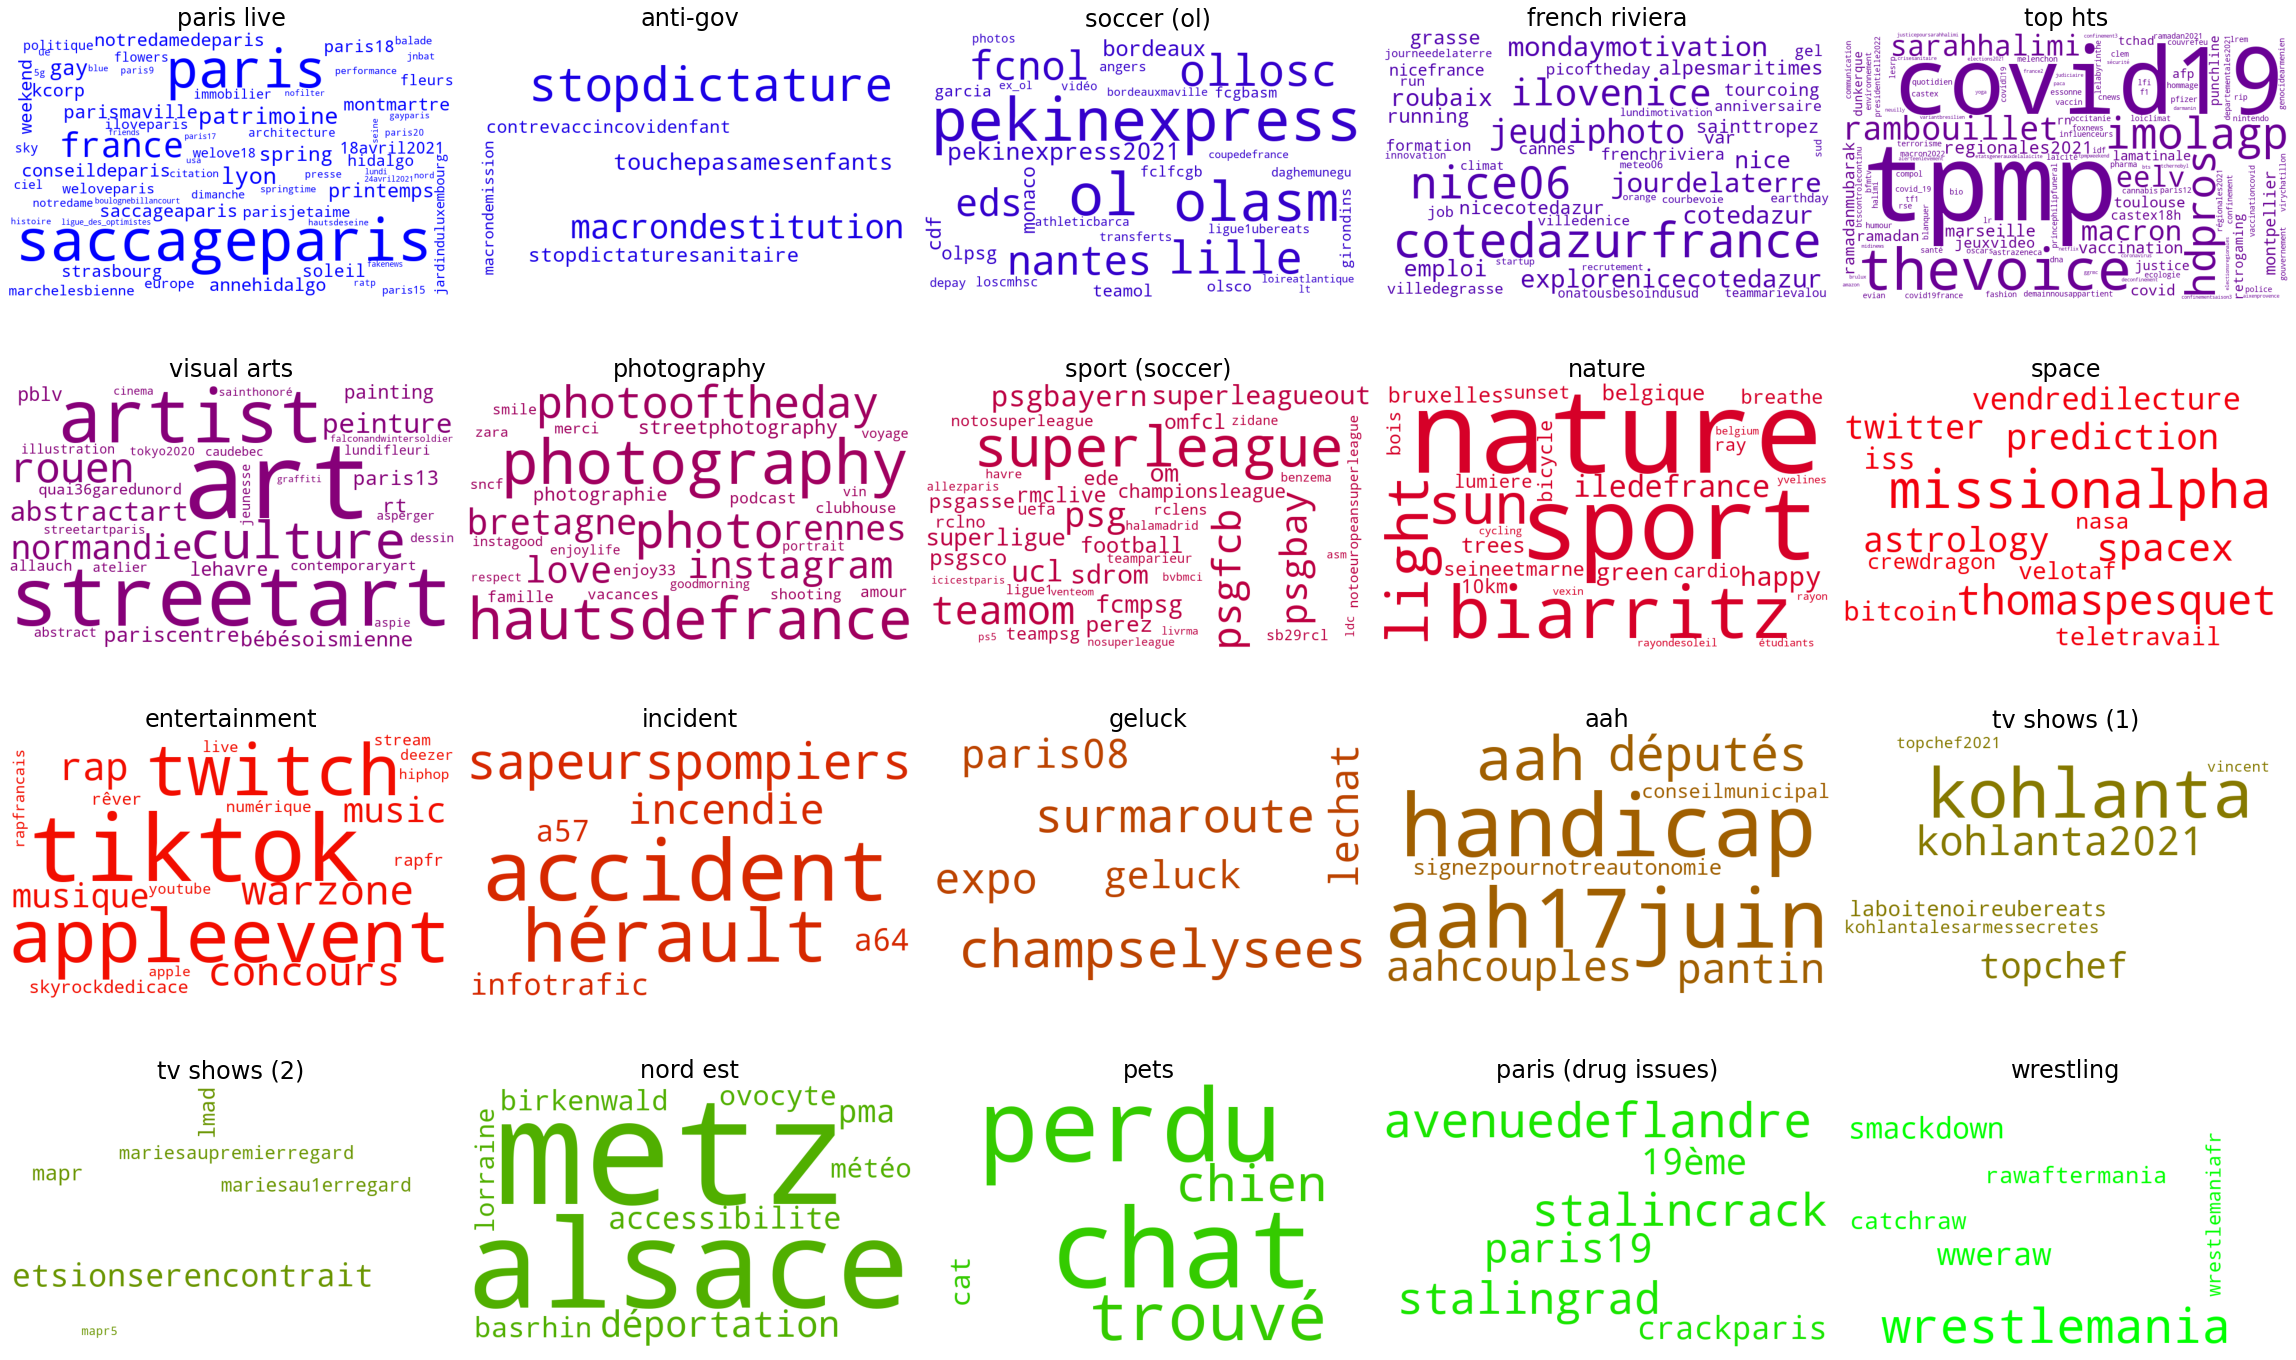

In [225]:
fig = plt.figure(figsize=(32,20))
cmap = cm.get_cmap('brg')

k = np.linspace(0, 1, df_louvain.shape[0])

for i, topic in df_louvain.iterrows():
    c = cmap(k[i])
    c = c[:3]
    c = tuple([int(k*255) for k in c])
    data = dict()
    for word in topic["hashtags"]:
        data[word] = ht_counts[word]
    wc = WordCloud(width=800
                   , height=480
                   , color_func=lambda *args, **kwargs: c
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(4, 5, i+1)
    ax.set_title(topic["name"], fontsize=24)
    ax.imshow(wc)
    plt.axis('off')
plt.tight_layout()
plt.show()
# fig.savefig('topic_wordcloud_louvain.eps', bbox_inches='tight')
# fig.savefig('topic_wordcloud_louvain.png', bbox_inches='tight', dpi=300)

In [226]:
# Create empty dictionaries ||| FOR LOUVAIN
modularity_class = {}
modularity_color = {}
# random colors to be assigned
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(communities_louvain_arr))]
#Loop through each community in the network
for community_number, community in enumerate(communities_louvain_arr):
    #For each member of the community, add their community number and a distinct color
    # define random color for community
    rd_com_color = color[community_number]
    for name in community: 
        modularity_class[name] = community_number
        modularity_color[name] = rd_com_color#Category20[nb_com][community_number]

In [227]:
# Add modularity class and color as attributes from the network above
nx.set_node_attributes(G, modularity_class, 'modularity_class')
nx.set_node_attributes(G, modularity_color, 'modularity_color')
# also add a size attribute
nx.set_node_attributes(G, ht_counts, 'count')

In [228]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [229]:
output_notebook()

Loading BokehJS ...

In [ ]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Choose a title!
title = 'Hashtags Network — Louvain communities'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Hashatag", "@index"),
        ("Count", "@count"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS
              , tools="pan,wheel_zoom,save,reset, tap"
              , active_scroll='wheel_zoom'
              , x_range=Range1d(-10.1, 10.1)
              , y_range=Range1d(-10.1, 10.1)
              , plot_width=800
              , plot_height=800
              , title=title
             )

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.1, line_width="weight")

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

# Contingency matrix

In [230]:
geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

In [231]:
dep_tweets_hashtags = pd.merge(df_ht[["hashtags", "dep_code"]]
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)

dep_tweets_hashtags["code"].astype(str)
dep_tweets_hashtags.sample(3)

,hashtags,dep_code,code,nom,geometry
181511,[],91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
22319,[],93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
225517,[],94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."


In [232]:
for i, hts_com in enumerate(df_louvain["hashtags"]):
    dep_tweets_hashtags[topic_label[i]] = [np.sum([ht in hts_com for ht in hts_tweet])
                                              for hts_tweet in dep_tweets_hashtags["hashtags"]]

In [233]:
dep_tweets_hashtags.sample(3)

,hashtags,dep_code,code,nom,geometry,paris live,anti-gov,soccer (ol),french riviera,top hts,...,entertainment,incident,geluck,aah,tv shows (1),tv shows (2),nord est,pets,paris (drug issues),wrestling
79050,[],75,75,Paris,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163317,[],69,69,Rhône,"POLYGON ((4.38808 46.21979, 4.38719 46.22048, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115571,[teamom],13,13,Bouches-du-Rhône,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [234]:
df_dep_louvain = dep_tweets_hashtags.groupby("nom").sum()
df_dep_louvain.sample(3)

,paris live,anti-gov,soccer (ol),french riviera,top hts,visual arts,photography,sport (soccer),nature,space,entertainment,incident,geluck,aah,tv shows (1),tv shows (2),nord est,pets,paris (drug issues),wrestling
nom,,,,,,,,,,,,,,,,,,,,
Pas-de-Calais,15.0,0.0,70.0,9.0,41.0,2.0,10.0,65.0,7.0,14.0,10.0,0.0,0.0,0.0,18.0,4.0,0.0,110.0,0.0,0.0
Gironde,41.0,0.0,107.0,14.0,87.0,20.0,66.0,53.0,6.0,6.0,11.0,1.0,0.0,0.0,34.0,22.0,0.0,179.0,0.0,8.0
Alpes-Maritimes,65.0,0.0,75.0,523.0,169.0,64.0,24.0,45.0,6.0,11.0,10.0,6.0,0.0,0.0,57.0,19.0,3.0,48.0,0.0,0.0


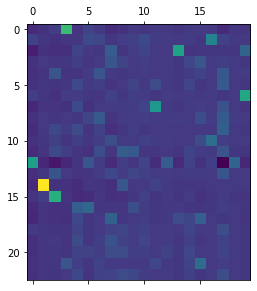

In [269]:
obs = df_dep_louvain.to_numpy()
chi2, p, dof, ex = stats.chi2_contingency(obs)
cont_mat = pd.DataFrame(columns=df_dep_louvain.columns, index=df_dep_louvain.index, dtype=float)

for i, row in enumerate(obs):
    for j, n in enumerate(row):
        cont_mat.iloc[i, j] = (n - ex[i, j])/np.sqrt(ex[i, j]) # according to https://docs.cortext.net/contingency-matrix/
plt.matshow(cont_mat)

In [270]:
# cont_mat['sum_x'] = cont_mat.where(cont_mat > 0).sum(1)
# cont_mat.sort_values(by="sum_x", ascending=True, inplace=True)
# cont_mat.drop('sum_x', inplace=True, axis=1)
# cont_mat = cont_mat.T
# cont_mat['sum_x'] = cont_mat.where(cont_mat > 0).sum(1)
# cont_mat.sort_values(by="sum_x", ascending=False, inplace=True)
# cont_mat.drop('sum_x', inplace=True, axis=1)
# cont_mat = cont_mat.T

# plt.matshow(cont_mat.to_numpy())

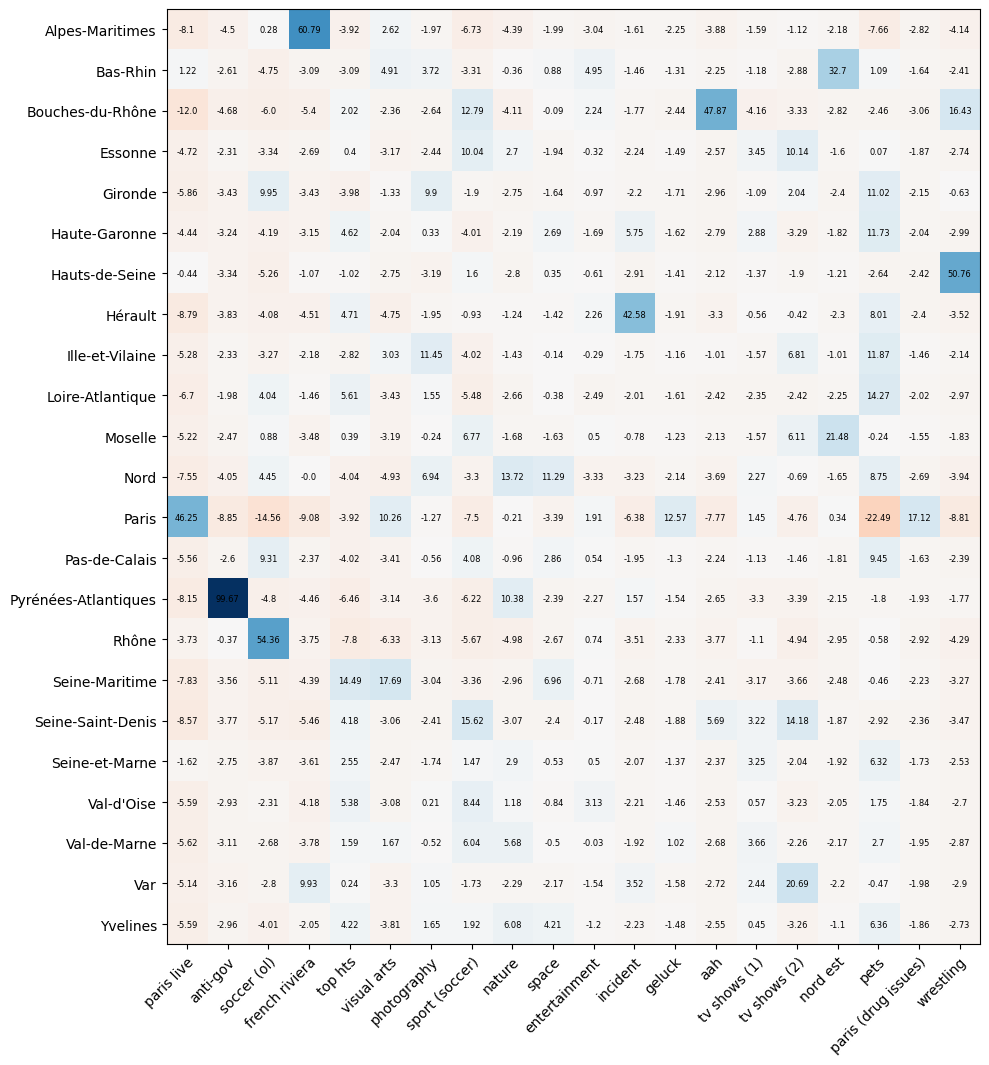

In [271]:
fig, ax = plt.subplots(1,1,figsize=(10,20), dpi=100)

departments = cont_mat.index.to_list()
hashtags = cont_mat.columns.to_list()

max_abs_value = np.max([np.abs(cont_mat.max().max()), np.abs(cont_mat.min().min())])

im = ax.imshow(cont_mat
               , cmap='RdBu'
               #, alpha=0.8
               , vmin=-max_abs_value
               , vmax=max_abs_value
              )

# We want to show all ticks...
ax.set_xticks(np.arange(len(hashtags)))
ax.set_yticks(np.arange(len(departments)))
# ... and label them with the respective list entries
ax.set_xticklabels(hashtags)
ax.set_yticklabels(departments)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(departments)):
    for j in range(len(hashtags)):
        text = ax.text(j, i, cont_mat.iloc[i, j].round(decimals=2),
                       ha="center", va="center", color="black", size=6)

fig.tight_layout()
plt.show()
# fig.savefig('contingency_matrix_louvain.eps', bbox_inches='tight')

In [272]:
 df_dep_louvain.T

nom,Alpes-Maritimes,Bas-Rhin,Bouches-du-Rhône,Essonne,Gironde,Haute-Garonne,Hauts-de-Seine,Hérault,Ille-et-Vilaine,Loire-Atlantique,...,Pas-de-Calais,Pyrénées-Atlantiques,Rhône,Seine-Maritime,Seine-Saint-Denis,Seine-et-Marne,Val-d'Oise,Val-de-Marne,Var,Yvelines
paris live,65.0,67.0,31.0,34.0,41.0,47.0,121.0,26.0,10.0,25.0,...,15.0,7.0,133.0,26.0,26.0,51.0,25.0,31.0,37.0,26.0
anti-gov,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,4.0,...,0.0,316.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
soccer (ol),75.0,1.0,30.0,13.0,107.0,12.0,15.0,23.0,5.0,62.0,...,70.0,6.0,558.0,11.0,14.0,7.0,18.0,19.0,19.0,9.0
french riviera,523.0,6.0,24.0,12.0,14.0,13.0,36.0,13.0,7.0,22.0,...,9.0,4.0,33.0,10.0,6.0,5.0,4.0,8.0,82.0,15.0
top hts,169.0,50.0,302.0,104.0,87.0,169.0,155.0,226.0,39.0,178.0,...,41.0,40.0,123.0,316.0,213.0,109.0,150.0,126.0,115.0,141.0
visual arts,64.0,35.0,37.0,6.0,20.0,14.0,18.0,6.0,23.0,7.0,...,2.0,7.0,5.0,124.0,15.0,7.0,6.0,30.0,7.0,3.0
photography,24.0,25.0,25.0,6.0,66.0,20.0,10.0,16.0,45.0,25.0,...,10.0,2.0,19.0,8.0,13.0,7.0,16.0,15.0,22.0,22.0
sport (soccer),45.0,19.0,290.0,124.0,53.0,30.0,102.0,77.0,9.0,18.0,...,65.0,9.0,63.0,45.0,225.0,54.0,110.0,102.0,45.0,65.0
nature,6.0,9.0,11.0,23.0,6.0,7.0,9.0,16.0,4.0,5.0,...,7.0,53.0,4.0,6.0,7.0,21.0,17.0,36.0,6.0,35.0
space,11.0,9.0,23.0,3.0,6.0,19.0,16.0,9.0,5.0,9.0,...,14.0,2.0,9.0,37.0,5.0,6.0,6.0,8.0,3.0,21.0


## Histograms

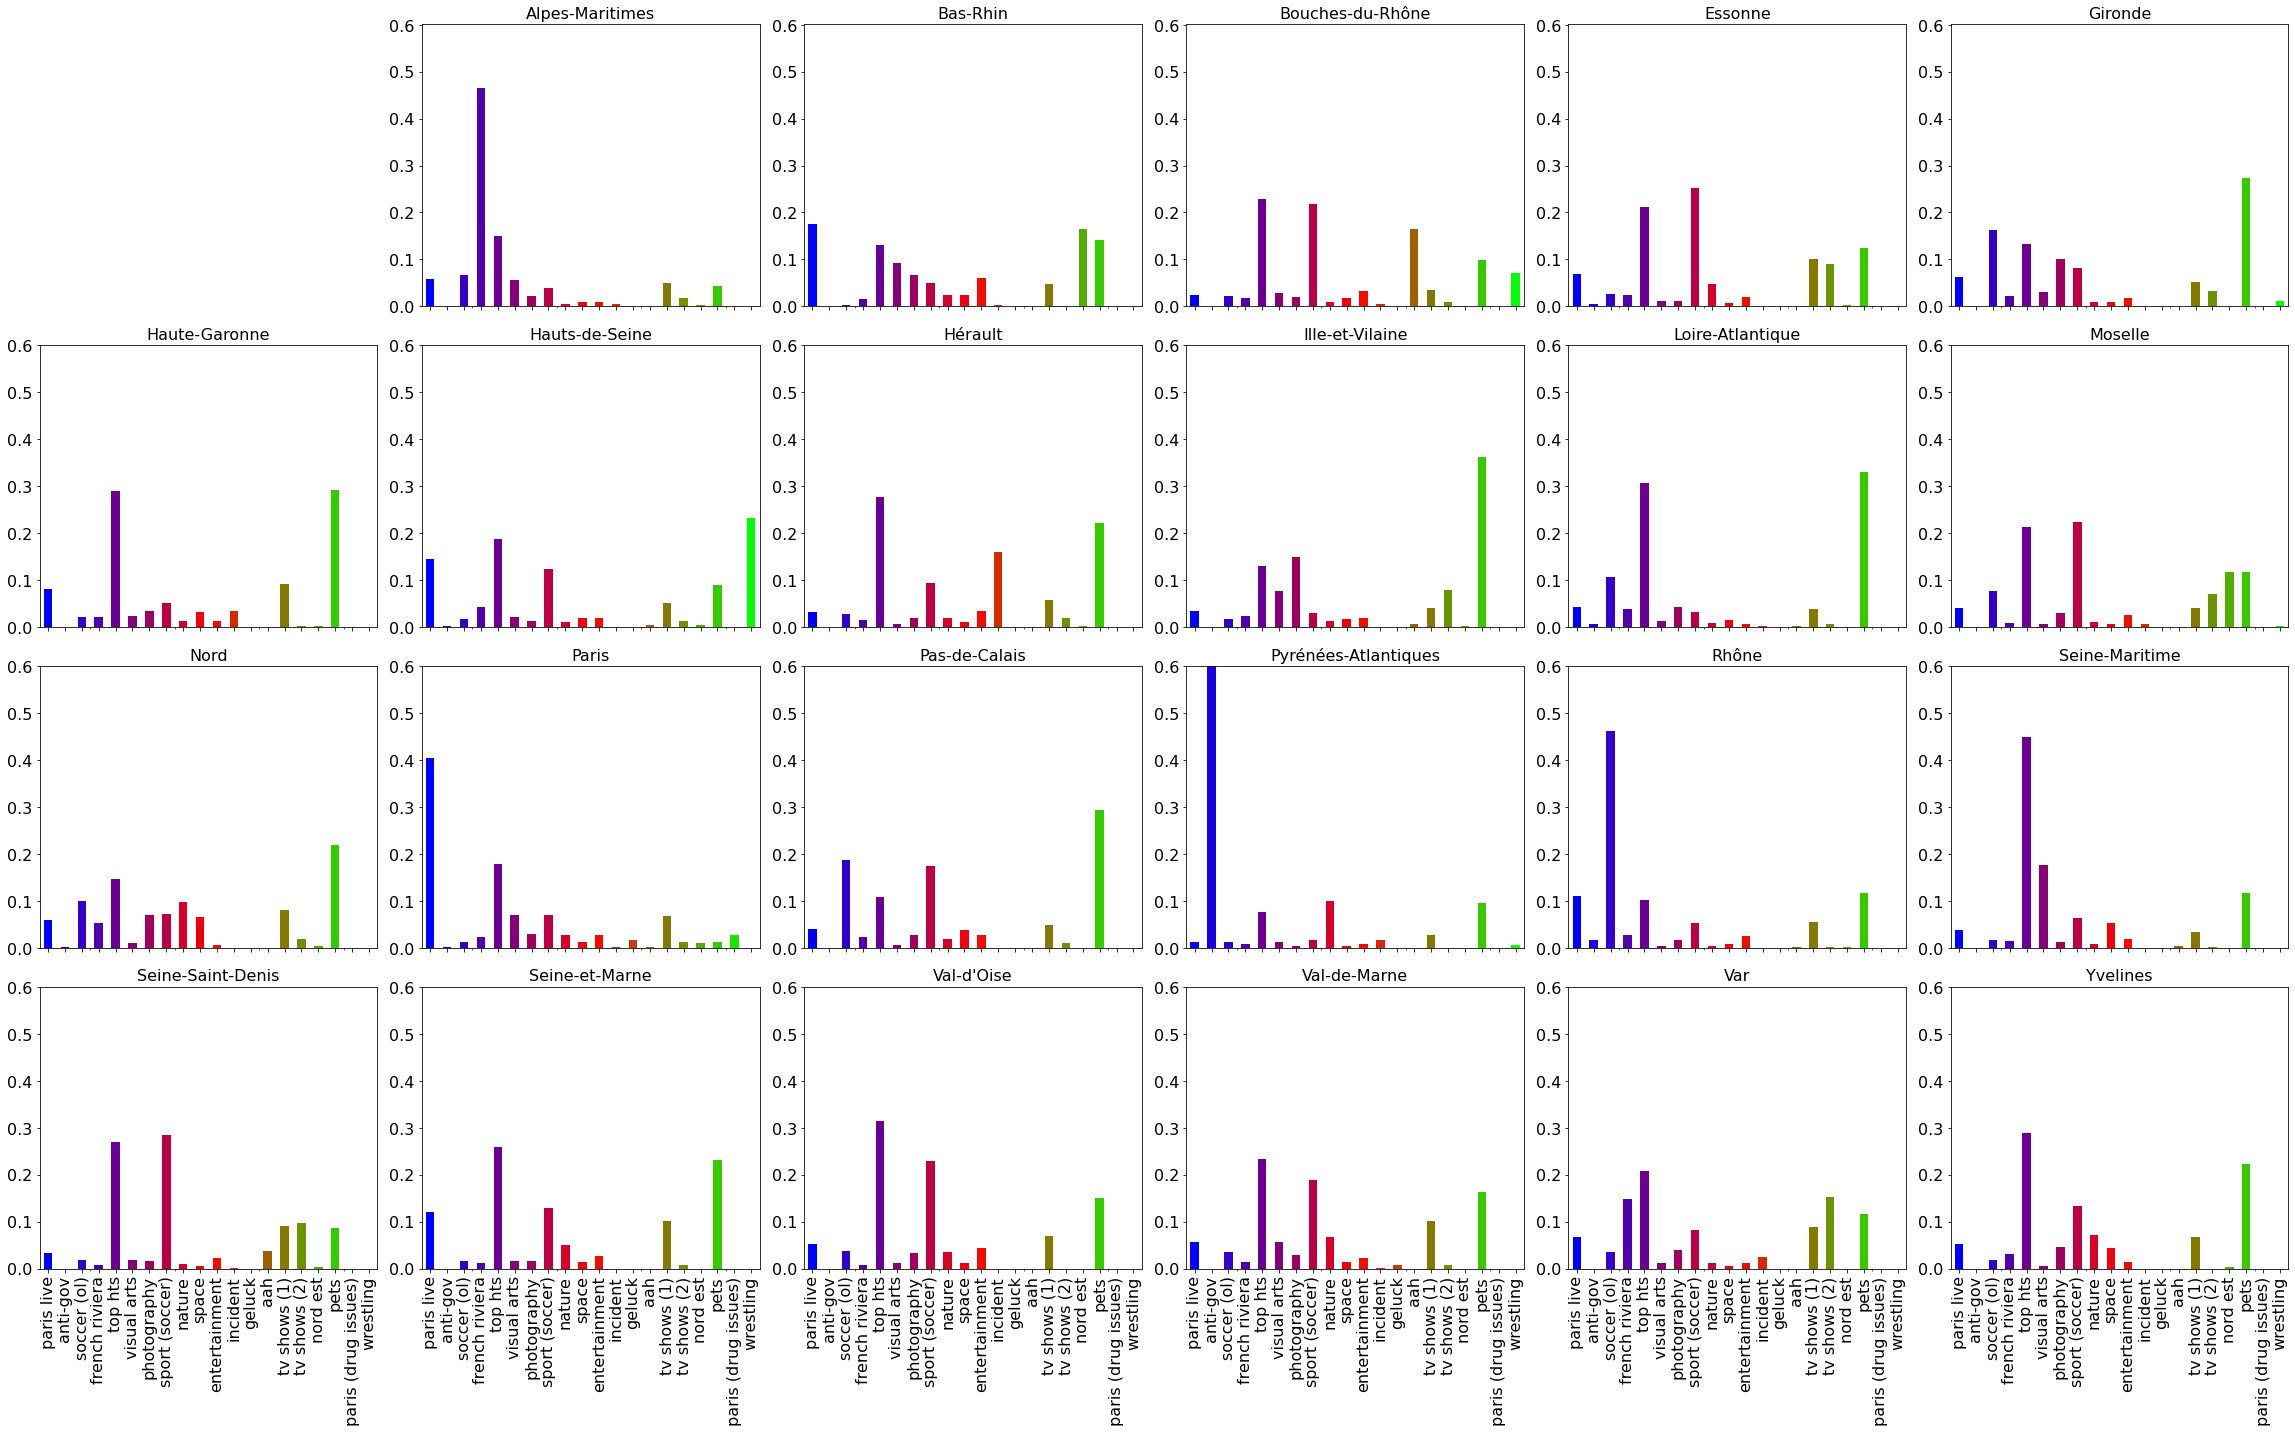

In [273]:
df_dep_louvain_norm = df_dep_louvain.div(df_dep_louvain.sum(axis=1), axis=0)
max_y = df_dep_louvain_norm.max().max()
fig = plt.figure(figsize=(32,20))

i = 0
prev_ax = None

cmap = cm.get_cmap('brg')
color = [cmap(i) for i in np.linspace(0,1, df_dep_louvain_norm.shape[1])]
for dep, louvain_coms in df_dep_louvain_norm.iterrows():
    
    ax = fig.add_subplot(4, 6, i+2, sharex=prev_ax)
    
    ax = louvain_coms.plot.bar(fontsize=16, color=color)
    prev_ax = ax
    ax.set_title(f"{dep}", fontsize=16)
    ax.set_ylim((0, max_y))
    # ax.imshow(wc)
    #plt.axis('off')
    i+=1
    
plt.tight_layout()
plt.show()
# fig.savefig('louvain_communities_histogram.eps')
# fig.savefig('louvain_communities_histogram.png', dpi=300)

In [285]:
df_hashtags_filtered = df_ht[[len(mat)>0 for mat in df_ht["hashtags"]]]
df_hashtags_filtered.shape

(25405, 26)

In [288]:
df_hashtags_filtered = pd.merge(df_hashtags_filtered
                 , gdf_departements
                 , how='inner'
                 , right_on="code"
                 , left_on="dep_code"
                 , validate = "many_to_one"
                ).reset_index(drop=True)

In [289]:
df_dep_hashtags = df_hashtags_filtered.groupby(["nom"]).count()[["id_str"]]
df_dep_hashtags.rename(columns={'id_str':'tweet_count'}, inplace=True)
df_dep_hashtags["nb_hashtags"] = df_hashtags_filtered.groupby(["nom"]).sum()["nb_hashtags"]
df_dep_hashtags["all_hashtags"] = [np.sum(df_hashtags_filtered[df_hashtags_filtered.nom==nom].hashtags)
                                  for nom in df_dep_hashtags.index]
df_dep_hashtags.sort_values(by="nb_hashtags", ascending=False, inplace=True)
df_dep_hashtags.head(3)

,tweet_count,nb_hashtags,all_hashtags
nom,,,
Paris,6396,12355,"[flinguage_fr, ffback, rambouillet, covid19fra..."
Bouches-du-Rhône,1621,2845,"[boycottlesanges, marseille, prado, rmclive, p..."
Rhône,1402,2575,"[birdsseenin2021, birdphotography, birding, ac..."


In [290]:
df_dep_ht = pd.merge(df_dep_hashtags
                         , gdf_departements
                         , how='inner'
                         , right_on="nom"
                         , left_on="nom"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
df_dep_ht["code"].astype(str)
df_dep_ht.shape

(23, 6)

In [291]:
df_dep_ht.head(3)

,nom,tweet_count,nb_hashtags,all_hashtags,code,geometry
0,Paris,6396,12355,"[flinguage_fr, ffback, rambouillet, covid19fra...",75,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ..."
1,Bouches-du-Rhône,1621,2845,"[boycottlesanges, marseille, prado, rmclive, p...",13,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1..."
2,Rhône,1402,2575,"[birdsseenin2021, birdphotography, birding, ac...",69,"POLYGON ((4.38808 46.21979, 4.38719 46.22048, ..."


In [279]:
df_dep_louvain.head(3)

,paris live,anti-gov,soccer (ol),french riviera,top hts,visual arts,photography,sport (soccer),nature,space,entertainment,incident,geluck,aah,tv shows (1),tv shows (2),nord est,pets,paris (drug issues),wrestling
nom,,,,,,,,,,,,,,,,,,,,
Alpes-Maritimes,65.0,0.0,75.0,523.0,169.0,64.0,24.0,45.0,6.0,11.0,10.0,6.0,0.0,0.0,57.0,19.0,3.0,48.0,0.0,0.0
Bas-Rhin,67.0,0.0,1.0,6.0,50.0,35.0,25.0,19.0,9.0,9.0,23.0,1.0,0.0,0.0,18.0,0.0,63.0,54.0,0.0,0.0
Bouches-du-Rhône,31.0,1.0,30.0,24.0,302.0,37.0,25.0,290.0,11.0,23.0,42.0,7.0,0.0,219.0,45.0,11.0,2.0,131.0,0.0,94.0


In [292]:
df_dep_ht = pd.merge(df_dep_ht
                         , cont_mat
                         , how='inner'
                         , right_on="nom"
                         , left_on="nom"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
df_dep_ht.head(3)

,nom,tweet_count,nb_hashtags,all_hashtags,code,geometry,paris live,anti-gov,soccer (ol),french riviera,...,entertainment,incident,geluck,aah,tv shows (1),tv shows (2),nord est,pets,paris (drug issues),wrestling
0,Paris,6396,12355,"[flinguage_fr, ffback, rambouillet, covid19fra...",75,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ...",46.251827,-8.846947,-14.563242,-9.083071,...,1.905328,-6.377050,12.574227,-7.766666,1.448665,-4.762294,0.344359,-22.485474,17.117348,-8.814835
1,Bouches-du-Rhône,1621,2845,"[boycottlesanges, marseille, prado, rmclive, p...",13,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1...",-11.999989,-4.676562,-6.004036,-5.399876,...,2.241833,-1.769165,-2.437251,47.870219,-4.161952,-3.328527,-2.820442,-2.464701,-3.063136,16.430890
2,Rhône,1402,2575,"[birdsseenin2021, birdphotography, birding, ac...",69,"POLYGON ((4.38808 46.21979, 4.38719 46.22048, ...",-3.725145,-0.369923,54.361671,-3.751839,...,0.740971,-3.508321,-2.327157,-3.766420,-1.101205,-4.937385,-2.946121,-0.580939,-2.924770,-4.289631


In [294]:
topic_data = {}
word2topic = {}
for i in range(len(df_louvain)):
    for ht in df_louvain.loc[i, 'hashtags']:
        topic_data[ht] = i
        word2topic[ht] = df_louvain.loc[i, 'name']

In [298]:
from shapely.geometry import Point
import random
import itertools
import branca.colormap as cmp
import folium

import json
from folium import IFrame
from folium import DivIcon

linear = cmp.LinearColormap(
    ['white', 'blue'],
    vmin=0, vmax=3000,
    caption='tweet_count' #Caption for Color scale or Legend
).to_step(12)

code = dep_tweet_ht_viz["code"].to_list()


cmap = cm.get_cmap('brg')


def style_function(feature):
    if feature["code"] in code:
        index = df_dep_ht[df_dep_ht["code"]==feature["code"]].index.values[0]
        tweet_num = df_dep_ht.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in df_dep_ht.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function,)
    pt = sim_geo.centroid

    loc = r["nom"]
    data = {}
    ht_counter = Counter(r["all_hashtags"])
    for ht in r["all_hashtags"]:
        if ht in word2topic:
            topic = word2topic[ht]
            prob = r[topic]
            if prob > 0:
                data[ht] = prob # *ht_counter[ht]
                
    def color(word, **kwargs):
        t = topic_data[word]
        c = cmap(1.0/(len(df_louvain))*t)[:3]
        c = tuple([int(k*255) for k in c])
        hexa = '#%02x%02x%02x' % c
        return hexa
        
    wc = WordCloud(width=160
                   , height=120
                   , max_words=200
                   , color_func=color
                   , background_color='white'
                   , scale= 1.0).generate_from_frequencies(data)
    svg = wc.to_svg()
    iframe = IFrame(svg, width=160+20, height=120+20)
    popup = folium.Popup(iframe, max_width=2650, sticky=True)
    popup.add_to(geo_j)
    geo_j.add_to(m)
    folium.map.Marker(
            [pt.y, pt.x],
            icon=DivIcon(
                icon_size=(10,10),
                icon_anchor=(0,0),
                html=f'<div style="font-size: 6pt">{loc}</div>',
                )
            ).add_to(m)
linear.add_to(m)
        
m.save("final_viz.html")   
m